# Adding context
Here we learn how to give a document as a context to the model so that the model's answers are based on this context

In [24]:
import os
import sys
import numpy as np
from dotenv import load_dotenv

current_path = os.getcwd()
parrent_path = os.path.abspath(os.path.join(current_path, '..'))
sys.path.append(parrent_path)

from Update_Git import git_add, git_commit, git_push

file_path = os.path.join(current_path, 'Test_4.ipynb')
git_add(file_path)
git_commit('Updated test 4')
git_push('main')

os.environ.pop("OPENAI_API_KEY", None) # Because it loads a key from some place I dont know!
env_path = os.path.join(current_path, ".env")
load_dotenv(dotenv_path=env_path)

True

### If we have a text for context

In [ ]:
from langchain_core.documents import Document
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, CommaSeparatedListOutputParser, JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

# Context
docA = Document(
    page_content= "FreeSurfer is brain imaging software originally developed by Bruce Fischl, Anders Dale, Martin Sereno, and Doug Greve.[2] Development and maintenance of FreeSurfer is now the primary responsibility of the Laboratory for Computational Neuroimaging"
)

# llm
model = ChatOpenAI(
    model = 'gpt-3.5-turbo',
    temperature=0.5
)

# Prompt
prompt = ChatPromptTemplate.from_template(
    """
    Answer the users questions:
    Context: {context}
    Question: {input}
"""
)

# Output Parser
parser = StrOutputParser()

# chain = prompt | model | parser
chain = create_stuff_documents_chain(
    prompt=prompt,
    llm=model,
    output_parser=parser
)

response = chain.invoke({
    "input": "What is FreeSurfer?",
    "context": [docA]
})

print(response)

### If the context is a webpage

![Screenshot 2025-06-16 at 23.09.36.png](<attachment:Screenshot 2025-06-16 at 23.09.36.png>)
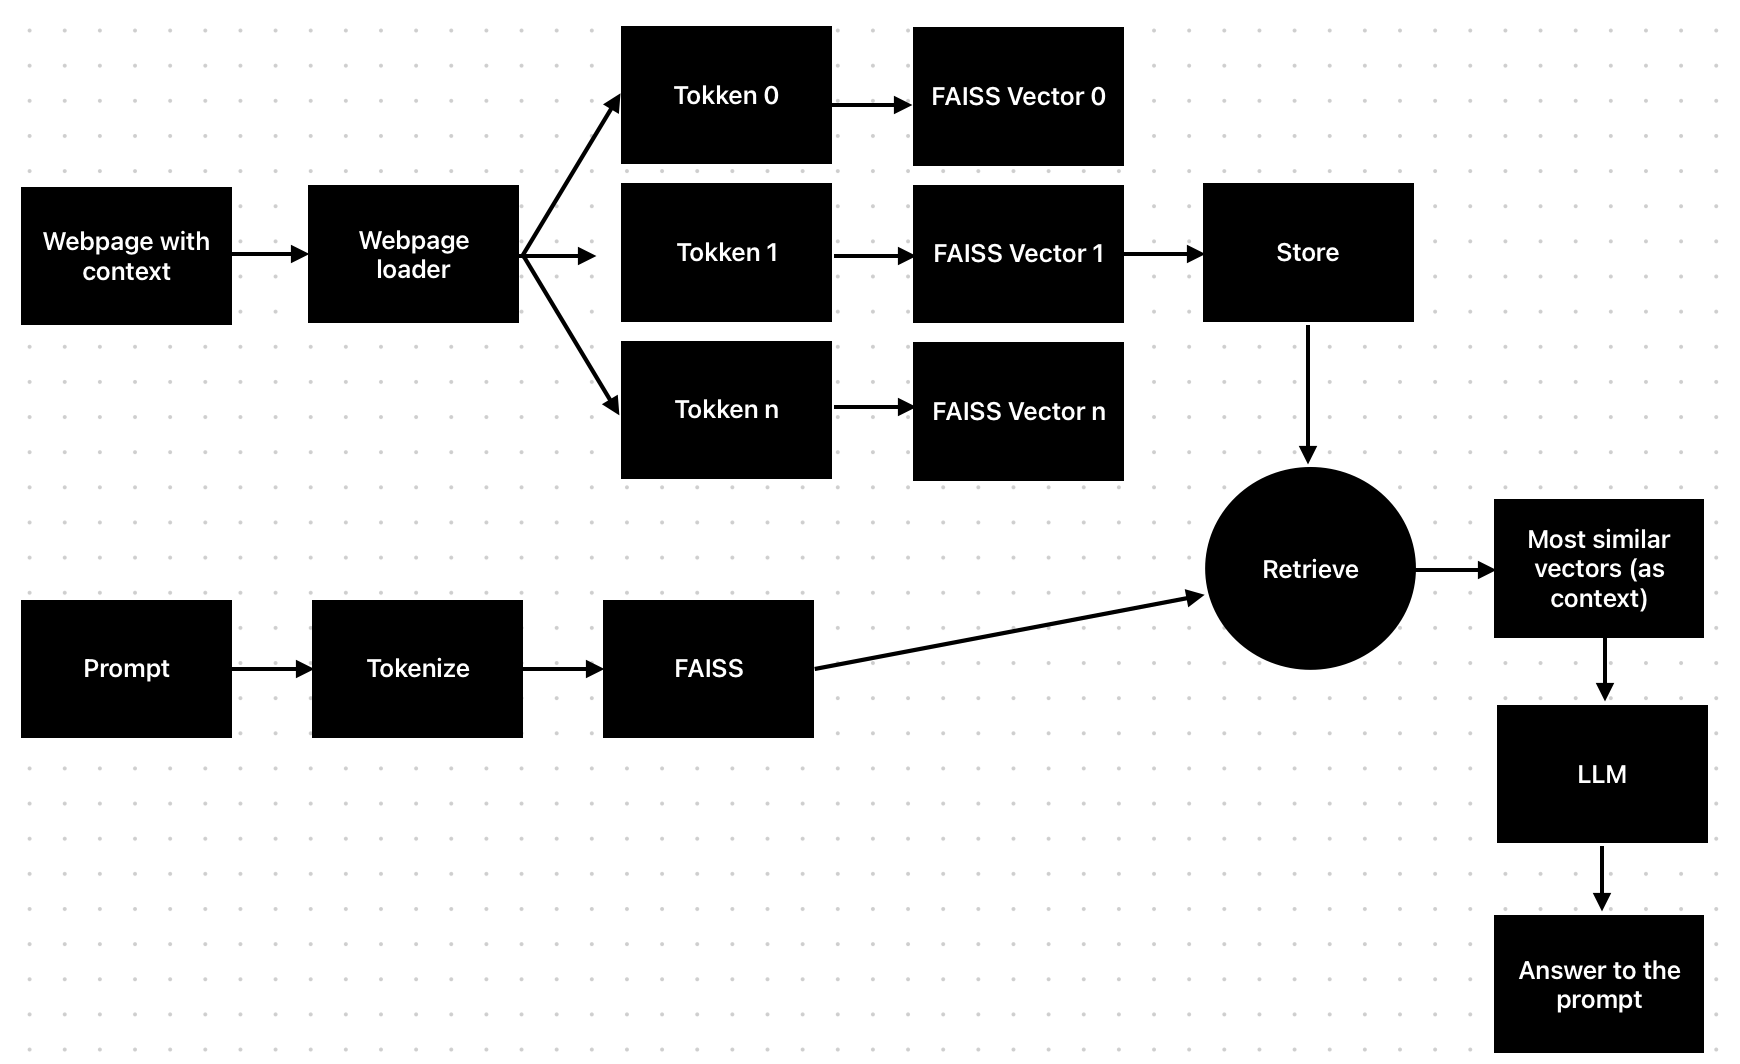

1. load content from webpage using a url
2. split the text into tokkens
3. create a FAISS vector database (FAISS: Facebook AI Similarity Search)
4. create llm
5. create prompt
6. create chain
7. retrieve

In [ ]:
#! pip install langchain_community
#! pip install faiss-cpu
#! pip install faiss-gpu
#! pip install beautifulsoup4


In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.faiss import FAISS
from langchain.chains import create_retrieval_chain


# Function to load and split documents from a given URL
def document_loader(url):
    loader = WebBaseLoader(url)  # Load the document from the web
    docs = loader.load()  # Extract the content
    
    # Split the document into smaller chunks for processing
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=200,  # Each chunk has a max size of 200 characters
        chunk_overlap=50  # Overlapping of 50 characters between chunks for context continuity
    )
    split_docs = splitter.split_documents(docs)  # Split the documents

    return split_docs  # Return the processed document chunks


# Function to create a FAISS vector database
def create_db(docs):
    embedding = OpenAIEmbeddings()  # Generate embeddings using OpenAI
    vector_store = FAISS.from_documents(docs, embedding=embedding)  # Store documents in FAISS index
    return vector_store  # Return the FAISS vector store


# Function to create a retrieval chain using the vector store
def create_chain(vector_store):

    # llm
    model = ChatOpenAI(
        model='gpt-3.5-turbo',  # Use GPT-3.5-turbo model
        temperature=0.5  # Set temperature for response variability
    )

    # prompt
    prompt = ChatPromptTemplate.from_template(
        """
        Answer the user's questions:
        Context: {context}
        Question: {input}
        """
    )

    # output parser
    parser = StrOutputParser()

    # Create the document processing chain
    chain = create_stuff_documents_chain(
        llm=model,
        prompt=prompt,
        output_parser=parser
    )

    retriever = vector_store.as_retriever()  # Convert vector store into a retriever
    retrieval_chain = create_retrieval_chain(retriever, chain)  # Create a retrieval-based chain

    return retrieval_chain  # Return the retrieval chain

# Load and preprocess the document
docs = document_loader("https://en.wikipedia.org/wiki/FreeSurfer")

# Create the FAISS vector store from the document
vector_store = create_db(docs)

# Create the retrieval chain using the vector store
chain = create_chain(vector_store)

# Query the retrieval chain with a sample question
response = chain.invoke({
    "input": "What is FreeSurfer?",
    "context": docs
})

# Print the answer from the model
print(response["answer"])
